### Transfer Learning EfficientNet regroupement IG et Blast

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_10_class.csv',index_col=0)

In [3]:
data_detour = pd.read_csv('../files_detour_256.csv',index_col=0)

In [4]:
# Garde seulement les images où le détourage possible pour comparaison avec/sans détourage
data = data[data['filename'].isin(data_detour['filename'])]

In [5]:
# Regroupement des blasts et IG en Blast
data['class'] = data['class'].replace('ig','blast')

In [6]:
data['class'].value_counts()

blast           7110
neutrophil      5391
lymphocyte      4612
eosinophil      3224
smudge          2898
monocyte        2716
platelet        2411
erythroblast    1969
basophil        1271
Name: class, dtype: int64

In [7]:
data.head()

,file_path,filename,class
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil


In [8]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

#### Utilisation d'un ImageDataGenerator

In [9]:
# Recadrage de l'image
def preprocess(img):
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)  # Preprocess de EfficientNet
    return img

In [10]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess,horizontal_flip=True, vertical_flip=True,
                                    rotation_range=180
                                                       )
test_generator = ImageDataGenerator(preprocessing_function=preprocess)

In [11]:
data_train_generator = data_generator.flow_from_dataframe(data_train, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32)

data_test_generator = data_generator.flow_from_dataframe(data_test, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32)

Found 25596 validated image filenames belonging to 9 classes.
Found 2845 validated image filenames belonging to 9 classes.


#### Transfer Learning avec modèle EfficientNet
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [12]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [13]:
# Création d'un modèle MobileNet
def model_efficientNet():
    base_model = EfficientNetB1(
        weights='imagenet',  
        input_shape=(256, 256, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.2)(x)
    # A Dense classifier 
    outputs = Dense(units=9,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
model = model_efficientNet()

In [15]:
#Entrainement
history = model.fit(data_train_generator, epochs = 16, validation_data = data_test_generator,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 2851s 4s/step - loss: 0.8307 - accuracy: 0.7144 - val_loss: 0.5043 - val_accuracy: 0.8418
Epoch 2/16
800/800 [==============================] - 2832s 4s/step - loss: 0.5936 - accuracy: 0.8048 - val_loss: 0.4462 - val_accuracy: 0.8559
Epoch 3/16
800/800 [==============================] - 2846s 4s/step - loss: 0.5407 - accuracy: 0.8262 - val_loss: 0.4033 - val_accuracy: 0.8728
Epoch 4/16
800/800 [==============================] - 2849s 4s/step - loss: 0.5014 - accuracy: 0.8388 - val_loss: 0.4097 - val_accuracy: 0.8703
Epoch 5/16
800/800 [==============================] - 2845s 4s/step - loss: 0.4739 - accuracy: 0.8454 - val_loss: 0.4024 - val_accuracy: 0.8699
Epoch 6/16
800/800 [==============================] - 2848s 4s/step - loss: 0.4717 - accuracy: 0.8488 - val_loss: 0.3651 - val_accuracy: 0.8854
Epoch 7/16
800/800 [==============================] - 2870s 4s/step - loss: 0.4558 - accuracy: 0.8524 - val_loss: 0.3980 - val_accuracy:

In [16]:
model.save_weights("efficientnet_9_weights_augm")

#### Prédiction sur les données d'évaluation

In [14]:
data_eval_generator = test_generator.flow_from_dataframe(data_eval, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32,shuffle=False)

Found 3161 validated image filenames belonging to 9 classes.


In [18]:
model.evaluate(data_eval_generator)

99/99 [==============================] - 313s 3s/step - loss: 0.3545 - accuracy: 0.8852


[0.35451698303222656, 0.8851629495620728]

 * Score similaire à 10 classes

#### Fine Tunning

In [18]:
model = model_efficientNet()
model.load_weights("efficientnet_9_weights_augm")

In [19]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 256, 256, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_2[0][0]            
_______________________________________________________________________________________

In [20]:
# Unfreeze dernier block Efficient 7b
for layer in model.layers[-26:]:
    layer.trainable = True

In [21]:
model.compile(optimizer=Adam(learning_rate=1e-4) ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3)

In [23]:
history = model.fit(data_train_generator, epochs = 16, validation_data = data_test_generator,callbacks=[reduce_lr,early_stopping])

Epoch 1/16
800/800 [==============================] - 3928s 5s/step - loss: 0.4692 - accuracy: 0.8547 - val_loss: 0.3044 - val_accuracy: 0.9002
Epoch 2/16
800/800 [==============================] - 3747s 5s/step - loss: 0.3526 - accuracy: 0.8855 - val_loss: 0.2727 - val_accuracy: 0.9062
Epoch 3/16
800/800 [==============================] - 3714s 5s/step - loss: 0.3154 - accuracy: 0.8985 - val_loss: 0.2679 - val_accuracy: 0.9107
Epoch 4/16
800/800 [==============================] - 3649s 5s/step - loss: 0.2999 - accuracy: 0.9009 - val_loss: 0.2644 - val_accuracy: 0.9132
Epoch 5/16
800/800 [==============================] - 3589s 4s/step - loss: 0.2900 - accuracy: 0.9053 - val_loss: 0.2495 - val_accuracy: 0.9135
Epoch 6/16
800/800 [==============================] - 3606s 5s/step - loss: 0.2706 - accuracy: 0.9124 - val_loss: 0.2603 - val_accuracy: 0.9139
Epoch 7/16
800/800 [==============================] - 3632s 5s/step - loss: 0.2632 - accuracy: 0.9151 - val_loss: 0.2449 - val_accuracy:

In [24]:
model.save_weights("efficientnet_9_weights_augm")

#### Evaluation des résultats

In [25]:
model.evaluate(data_eval_generator)

99/99 [==============================] - 300s 3s/step - loss: 0.2765 - accuracy: 0.9117


[0.27653956413269043, 0.911736786365509]

In [26]:
#Classes prédites
predict = model.predict(data_eval_generator)

In [27]:
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in data_eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.82      0.95      0.88       118
       blast       0.89      0.88      0.89       711
  eosinophil       0.97      0.97      0.97       320
erythroblast       0.97      0.86      0.91       217
  lymphocyte       0.90      0.92      0.91       467
    monocyte       0.84      0.86      0.85       264
  neutrophil       0.97      0.94      0.96       580
    platelet       0.97      1.00      0.98       231
      smudge       0.81      0.83      0.82       253

    accuracy                           0.91      3161
   macro avg       0.91      0.91      0.91      3161
weighted avg       0.91      0.91      0.91      3161



In [28]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,
basophil,112,3,0,1,0,1,0,1,0
blast,20,629,1,1,9,24,6,0,21
eosinophil,1,0,311,0,0,1,3,0,4
erythroblast,1,4,0,186,16,0,2,7,1
lymphocyte,0,19,0,3,428,8,0,0,9
monocyte,2,18,1,0,3,228,2,0,10
neutrophil,1,10,8,0,5,6,547,0,3
platelet,0,0,0,0,1,0,0,230,0
smudge,0,23,0,0,11,3,5,0,211


> Confusion importante blaste/monocyte, blaste/smudge

In [39]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['class'],'Prédiction':eval_predict_class_name}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [46]:
predict_by_class = []
for i in range(9):
    indexes = predict_correct[predict_correct['Réalité']==lst_classes[i]].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

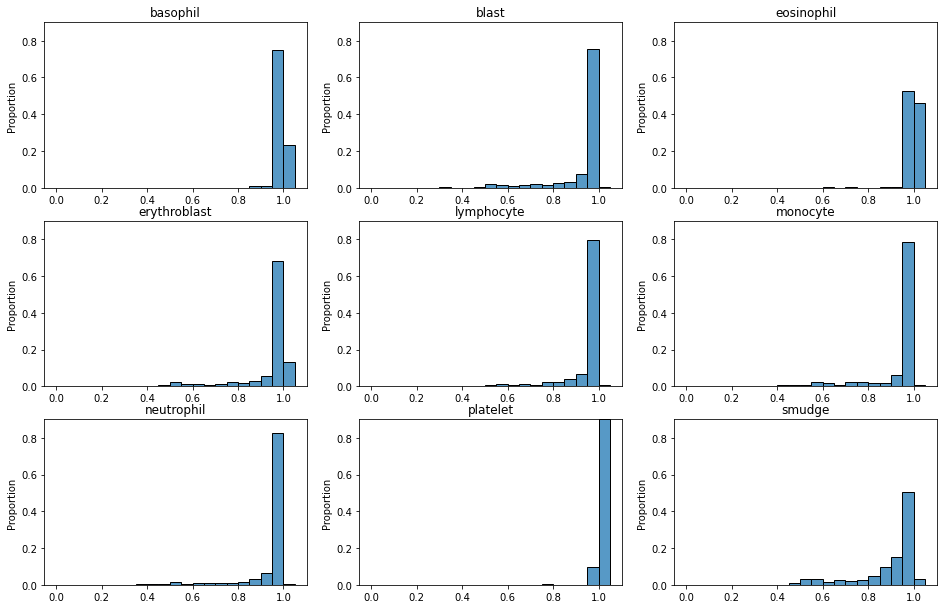

In [48]:
fig = plt.figure(figsize=(16,14))
for i in range(9):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

In [49]:
# Cellule mal prédite => % sur la classe choisie
predict_incorrect = compare[compare['Réalité']!=compare['Prédiction']]
pourcent_incorrect = predict[predict_incorrect.index].max(axis = 1)

<AxesSubplot:ylabel='Proportion'>

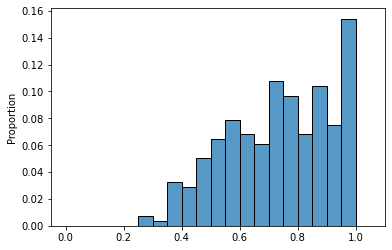

In [50]:
fig = plt.figure(figsize=(6,4))
sns.histplot(x=pourcent_incorrect,stat='proportion', bins = np.arange(0,1.1,0.05) )

> Classe mal prédite avec des % important


### GRAD CAM

In [52]:
import gradcam_dataset

In [53]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 256, 256, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_2[0][0]            
_______________________________________________________________________________________

Total params: 8,545,424
Trainable params: 3,945,945
Non-trainable params: 4,599,479
__________________________________________________________________________________________________


In [54]:
img_size = (256, 256)
last_conv_layer_name = "top_conv"

In [55]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

##### BASOPHIL

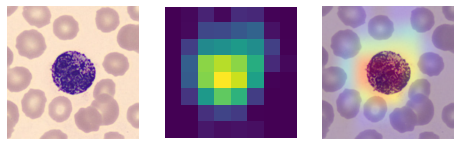

In [56]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

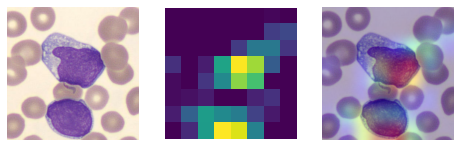

In [57]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

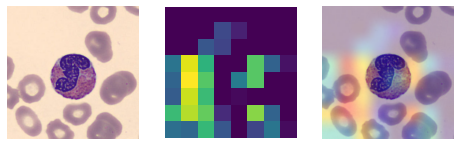

In [58]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

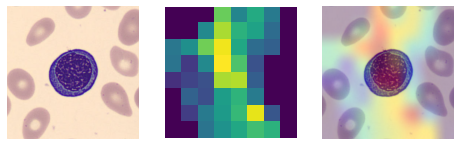

In [59]:
path = data[data['filename']=='ERB_7315.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### LYMPHOCYTE

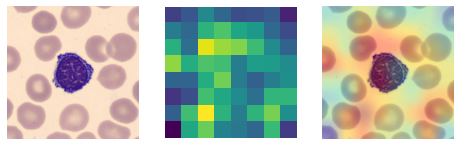

In [65]:
path = data[data['filename']=='LY_32523.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### MONOCYTE

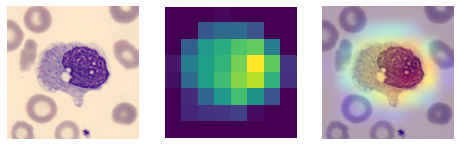

In [66]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### NEUTROPHIL

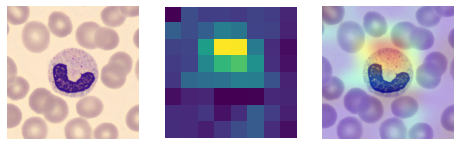

In [67]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### PLATELET

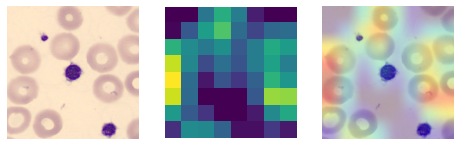

In [68]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### SMUDGE

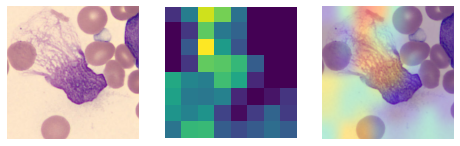

In [69]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)